# Ejercitando con Apache Spark y Python a través de PySpark

El objetivo de esta guía es repasar los conceptos básicos de Spark a través de la resolución de ejercicios con la API para Python, PySpark, para dar soporte a la computación paralela sobre grandes colecciones de datos en un contexto de procesamiento distribuido.
<br /> <br />
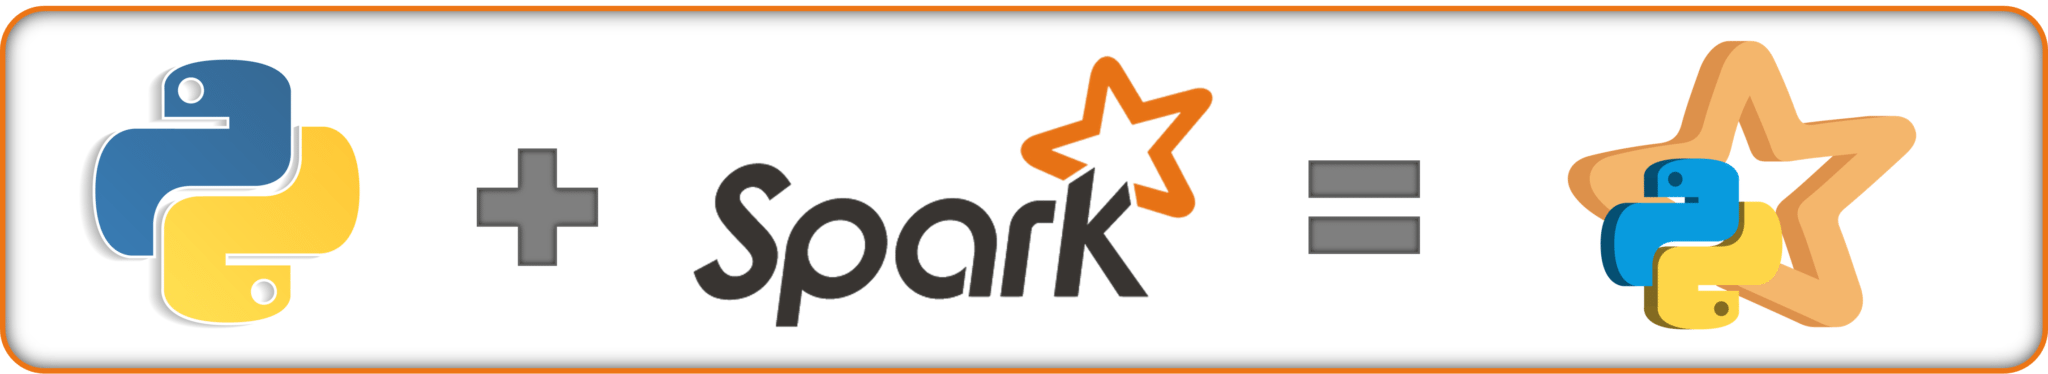

## Introducción a Spark

Las aplicaciones Spark se ejecutan como conjuntos independientes de procesos en un clúster, coordinados por el objeto SparkContext en su programa principal (llamado programa controlador).

Específicamente, para ejecutarse en un clúster, SparkContext puede conectarse a varios tipos de administradores de clústeres (ya sea el administrador de clúster independiente de Spark, Mesos o YARN), que asignan recursos entre aplicaciones. Una vez conectado, Spark adquiere ejecutores en nodos en el clúster, que son procesos que ejecutan cálculos y almacenan datos para su aplicación. A continuación, envía el código de su aplicación (definido por archivos JAR o Python pasados a SparkContext) a los ejecutores. Finalmente, SparkContext envía tareas a los ejecutores para que las ejecuten.

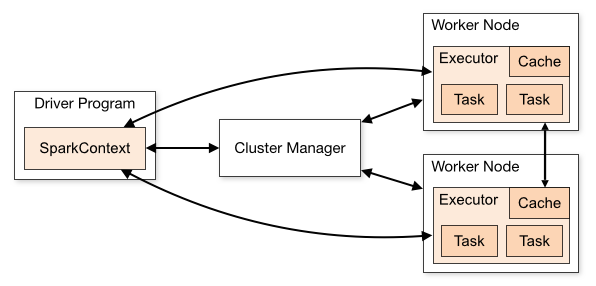

### Arquitectura y Funcionamiento de Spark

En lineas generales, se plantea una serie de cuestiones respecto al funcionamiento de Spark en función del esquema anterior:
1. Cada aplicación tiene sus propios _executor processes_, que permanecen activos durante toda la aplicación y ejecutan _tasks_ en varios subprocesos. Esto tiene la ventaja de aislar las aplicaciones entre sí, tanto en el lado de la programación (cada controlador programa sus propias tareas) como en el lado del ejecutor (las tareas de diferentes aplicaciones se ejecutan en diferentes JVM). Sin embargo, también significa que los datos no se pueden compartir entre diferentes aplicaciones Spark (instancias de SparkContext) sin escribirlos en un sistema de almacenamiento externo.
1. Spark es independiente del _cluster manager_ subyacente. Siempre que pueda adquirir _executor processes_ y estos se comuniquen entre sí, es relativamente fácil ejecutarlo incluso en un _cluster manager_ que también admita otras aplicaciones (por ejemplo, Mesos o YARN).
1. El _driver program_ debe escuchar y aceptar conexiones entrantes de sus ejecutores a lo largo de su vida. Como tal, el _driver program_ debe ser direccionable en red desde los _worker nodes_.
1. Debido a que el _driver_ programa tareas en el clúster, debe ejecutarse cerca de los _worker nodes_, preferiblemente en la misma red de área local.


## Programando en modo PySpark

__Ejercicio: Vamos a volver a trabajar sobre el ejercicio que resolvimos con  MapReduce en el cual desarrollaremos un proceso que nos permita realizar un conteo de palabras para saber, en un supuesto dataset del orden de los petabytes, la cantidad de veces que aparece cada palabra.__
<br /> <br />
Para comenzar a trabajar con PySpark, instalamos la librería pyspark, Java 8 y seteamos las variables de entorno para que no devuelva error:

Luego, inicializamos el Spark Context seteando el _master_ y el nombre de la aplicación.

El siguiente ejemplos muestra la forma mínima de inicializar un SparkContext, donde se pasan dos parámetros:
- Una URL de clúster, a saber, _local_ en el ejemplo, que le dice a Spark cómo conectarse a un clúster. En Spark, _local_ es un valor especial que ejecuta Spark en un _thread_ en la máquina local, sin conectarse a un clúster.
- Un nombre de aplicación, en nuestro caso _Conteo de palabras_. Este nombre identificará la aplicación en el _cluster manager_ si nos conectamos a un clúster.

In [1]:
from pyspark import SparkConf, SparkContext

conf = SparkConf().setMaster("local").setAppName("Conteo de palabras")

# Inicializo el Spark Context
sc = SparkContext(conf = conf)

sc

23/09/20 20:28:06 WARN Utils: Your hostname, EliteX2 resolves to a loopback address: 127.0.1.1; using 192.168.5.94 instead (on interface wifi0)
23/09/20 20:28:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/20 20:28:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<SparkContext master=local appName=Conteo de palabras>

Después de haber inicializado un SparkContext, ya podemos utilizar todos los métodos para crear y manipular RDDs, Dataframes, y Datasets que son las estructuras de datos presentes en Spark.


## Trabajando con RDD's

Un RDD es simplemente una colección distribuida inmutable de elementos. En Spark, todo el trabajo se expresa ya sea creando nuevos RDD, transformando RDD existentes o llamando a operaciones en RDD para calcular un resultado. Bajo el capó, Spark distribuye automáticamente los datos contenidos en los RDD en su clúster y paraleliza las operaciones que realiza en ellos. __Los RDD son el concepto central en Spark__.
<br />
<br />
Si bien en las últimas versiones de Spark (mediados de 2019) el RDD como estructura de manipulación de datos pierde protagonismo, las estructuras nuevas que son utilizadas como los DataFrames y los DataSets son en realidad abstracciones de estos RDD que siguen estando en el núcleo de Spark.
<br />
<br />

### Creación de RDD
Cada RDD se divide en varias particiones, que se pueden calcular en diferentes nodos del clúster. Los RDD pueden contener cualquier tipo de objetos Python, Java o Scala, incluidas las clases definidas por el usuario.

Es posbile crear RDD de dos maneras: cargando un conjunto de datos externo o distribuyendo una colección de objetos (por ejemplo, una lista o conjunto).

En este caso lo haremos a través de cargar un conjunto de datos externos con el método __sc.textFile()__:

In [2]:
# Leo el archivo de texto
text_file = sc.textFile("input.txt")

In [5]:
text_file.take(3)

['Este es un ejemplo de un documento de texto.',
 'Este es otro ejemplo de documento.',
 'Cada documento tiene varias palabras.']

Una vez creados, los RDD ofrecen dos tipos de operaciones:
- Las __transformaciones__ construyen un nuevo RDD a partir de uno anterior.
- Las __acciones__, por otro lado, calculan un resultado basado en un RDD y lo devuelven al programa del controlador o lo guardan en un sistema de almacenamiento externo (por ejemplo, HDFS).

Las transformaciones y las acciones son diferentes debido a la forma en que Spark calcula los RDD. Aunque puede definir nuevos RDD en cualquier momento, Spark solo los computa de forma diferida, es decir, la primera vez que se utilizan en una acción. Este enfoque puede parecer inusual al principio, pero tiene mucho sentido cuando se trabaja con Big Data. Si Spark cargara y almacenara todas las líneas en el archivo tan pronto como escribiéramos _text_file = sc.textFile(...)_, desperdiciaría mucho espacio de almacenamiento o tiempo de procesamiento, dado que luego podemos filtrar  muchas líneas. En cambio, una vez que Spark ve la cadena completa de transformaciones, puede calcular solo los datos necesarios para su resultado.

### Acciones en Spark

A continuación se define un listado de las acciones más comunes y su utilización:
<br />-Para la columna __Result__ se calcula con un RDD con los valores {1, 2, 3, 3}.-

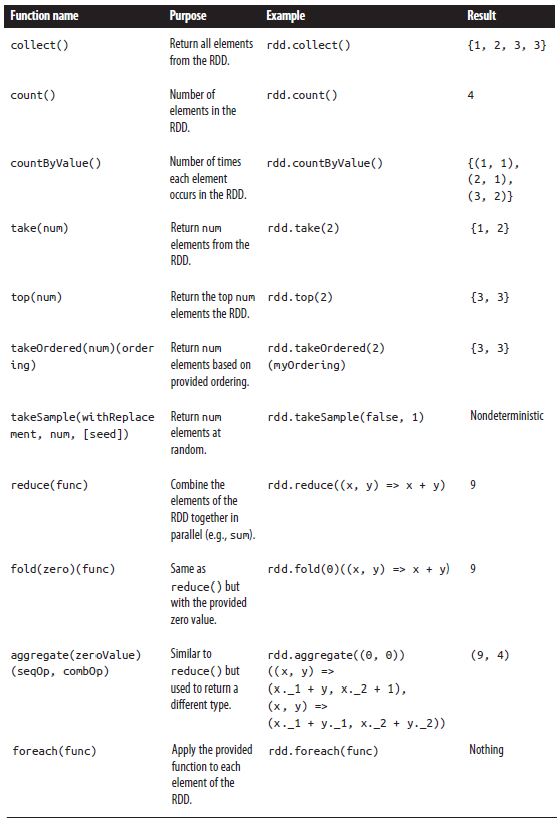

### Transformaciones en Spark

A continuación se define un listado de las transformaciones más comunes:
<br />-Para la columna __Result__ se calcula con un RDD con los valores {1, 2, 3, 3} en las operaciones unarias (map, flatMap, filter, distinct, sample) y para las binarias rdd={1, 2, 3} y other={3, 4, 5}.-

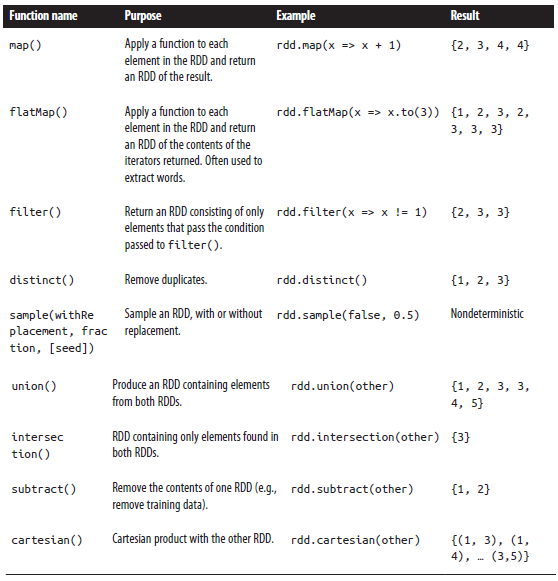

__Tip: ¿Cómo nos damos cuenta  si ejecutamos una transformación o una acción? Si la operación devuelve un RDD es transformación, de lo contrario es acción.__

Ahora que ocnocemos las RDD, las transformaciones y acciones, veamos como realizaríamos el _wordCount_ con Spark:

In [6]:
# Separo en palabras
words = text_file.flatMap(lambda line: line.split(" "))

# Transformo a clave-valor
key_value = words.map(lambda word: (word, 1))

# Agrupo por clave
wordCounts = key_value.reduceByKey(lambda a,b:a +b)

# Muestro el primero
wordCounts.first()

# Muestro todos
for x in wordCounts.collect():
     print(x)

# Mostramos la cantidad
wordCounts.count()

('Este', 2)
('es', 2)
('un', 2)
('ejemplo', 2)
('de', 3)
('documento', 2)
('texto.', 1)
('otro', 1)
('documento.', 1)
('Cada', 1)
('tiene', 1)
('varias', 1)
('palabras.', 1)
('Las', 1)
('palabras', 1)
('pueden', 1)
('repetirse', 1)
('en', 1)
('los', 1)
('documentos.', 1)


20

Finalmente, para apagar Spark, debemos llamaar al método stop () del SparkContext, en nuestro caso la variable _sc_:

In [9]:
sc.stop()

## Referencias

1. Learning Spark - Holden Karau, Andy Konwinski, Patrick Wendell and Matei Zaharia.  O’Reilly Media, Inc. 2015. ISBN 978-1-449-35862-4
1. Spark Overview. http://spark.apache.org/docs/latest/
1. PySpark – Word Count Example. https://pythonexamples.org/pyspark-word-count-example/
1. A Neanderthal’s Guide to Apache Spark in Python https://towardsdatascience.com/a-neanderthals-guide-to-apache-spark-in-python-9ef1f156d427
